In [1]:
using DrWatson
@quickactivate "JuliaTransformerLens"

In [2]:
# https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb#scrollTo=1MjsKyaGdkhC

Hi all! This is a replication of Neel Nanda's "Clean Transformer Demo" notebook in which I produce a bfrom-scratch gpt2 implementation in the Julia progamming language. This forms part of a reproducible scientific project created using Dr Watson (), and will be made publically available on github. 

I believe the Julia programming language has a lot to offer mechanistic interpretability research. This is mainly because Julia aims to solve the two-language problem (https://scientificcoder.com/how-to-solve-the-two-language-problem). Julia has the speed of C++ but the readability of Python. One can take slow julia code hobbled together for an exploratory project and make it performant without having to re-write it. Most importantly, automatic differentiation is almost native to the Julia programming language. This means that we dont have to use AD libraries like pytorch - we can just write julia code and differentiate through it e.g. with Enzyme (https://enzyme.mit.edu/julia/stable/). 

Crucially, I believe this makes the internals of ML architectures built in julia very transparent. There are no "pytorch functions", just functions. And so I believe it forms a great tool for learning and mechanistic interpretability. 

I plan to explore this in more detail over the next year. For now, see below a julia implementation of GPT2 using the "lux" AD library (https://lux.csail.mit.edu/stable/manual/interface). There are some schematics which aim to provide a visual explanation of embedding, positional embedding and attention, which I believe are the most "uniquely transpormer" aspects of the architecture. I have built in interoperatability functions between the python TransformerLens package (https://github.com/TransformerLensOrg/TransformerLens) and this notebook so that we can check our implementation as we go along, and load the original model weights.

I would recommend reading through Neel Nandas excellent colab and video turtorial alongside this notebook : https://www.youtube.com/watch?v=dsjUDacBw8o&t=1236s

I will be adding to this to make it more comprehensive at some point in the future.

Many thanks!

In [3]:
using PyCall

tl = pyimport("transformer_lens")

reference_gpt2 = tl.HookedTransformer.from_pretrained("gpt2-small", fold_ln=false, center_unembed=false, center_writing_weights=false)


/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


PyObject HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
     

## Load Packages

In [4]:
torch = pyimport("torch")
np = pyimport("numpy")
einops = pyimport("einops")

PyObject <module 'einops' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/einops/__init__.py'>

In [5]:
using Lux, Random, Optimisers, Zygote, Metal

using TensorCast, TensorOperations, Einsum

using LuxCore, Random, WeightInitializers

using StatsBase

using BenchmarkTools

using NNlib

using LinearAlgebra

using Images, FileIO

In [6]:
mps_device = torch.device("mps")

dev = gpu_device()

rng = Random.default_rng()

TaskLocalRNG()

## Lets look at some tokens

In [7]:
reference_text = "I love linear algebra"

tokens = reference_gpt2.to_tokens(reference_text)

tokens_array = tokens.cpu().detach().numpy()

logits, cache = reference_gpt2.run_with_cache(tokens);

In [8]:
tokens_array

1×5 Matrix{Int64}:
 50256  40  1842  14174  37139

In [9]:
id_to_token = Dict(value=>key for (key,value) in reference_gpt2.tokenizer.vocab);

In [10]:
[id_to_token[i] for i in tokens_array]

1×5 Matrix{String}:
 "<|endoftext|>"  "I"  "Ġlove"  "Ġlinear"  "Ġalgebra"

## Whats available in the TransformerLens package?

In [11]:
for k in keys(cache.cache_dict)
    if k[1:8] == "blocks.0"
        print(k)
        print("\n")
    end
end

blocks.0.ln1.hook_normalized
blocks.0.hook_mlp_out
blocks.0.ln2.hook_normalized
blocks.0.ln1.hook_scale
blocks.0.attn.hook_v
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.0.attn.hook_q
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.ln2.hook_scale
blocks.0.hook_attn_out
blocks.0.attn.hook_z
blocks.0.hook_resid_mid
blocks.0.mlp.hook_post
blocks.0.attn.hook_k
blocks.0.mlp.hook_pre


## Create a config for GPT-2 like transformers

In [12]:
mutable struct TConfig
    d_model::Int 
    debug::Bool 
    layer_norm_eps::Float32 
    d_vocab::Int 
    init_range::Float32 
    n_ctx::Int
    d_head::Int
    d_mlp::Int
    n_heads::Int
    n_layers::Int
end

# tokens 0 - 50256

TConfig(debug) = TConfig(768,debug,1e-5,50257,0.02,1024,64,3072,12,12)

cfg = TConfig(true)

TConfig(768, true, 1.0f-5, 50257, 0.02f0, 1024, 64, 3072, 12, 12)

## Create some interoperatibility functions for testing the output of components

In [13]:
function w_from_pytorch(py_ln::PyObject,dims,w_alias)
    w_ref = py_ln.state_dict()[w_alias].cpu().detach().numpy()
    w_ref_tensor = reshape(w_ref,dims)
end

function b_from_pytorch(py_ln::PyObject,dims,b_alias)
    b_ref = py_ln.state_dict()[b_alias].cpu().detach().numpy()
    b_ref_tensor = reshape(b_ref,dims)
end

function multi_w_from_pytorch(py_ln::PyObject,d_dict)

    return_dict = Dict()
    
    for (W_name,dims) in d_dict
        w_ref = py_ln.state_dict()[W_name].cpu().detach().numpy()
        w_ref_tensor = reshape(w_ref,dims)
        return_dict[W_name] = w_ref_tensor
    end

    return_dict
end

function multi_b_from_pytorch(py_ln::PyObject,d_dict)

    return_dict = Dict()
    
    for (b_name,dims) in d_dict
        b_ref = py_ln.state_dict()[b_name].cpu().detach().numpy()
        b_ref_tensor = reshape(b_ref,dims)
        return_dict[b_name] = b_ref_tensor
    end

    return_dict
end

multi_b_from_pytorch (generic function with 1 method)

In [14]:
function rand_float_test(cls, shape)
    cfg = TConfig(true)
    layer = cls(cfg) 
    ps, st = LuxCore.setup(rng, layer)
    random_input = randn(Float32,shape)
    print("\rInput shape:", size(random_input))
    output = LuxCore.apply(layer, random_input, ps, st)[1]
    print("\rOutput shape:", size(output))
    print("\rEnd Float Test")
    return output
end

function rand_int_test(cls, shape)
    cfg = TConfig(true)
    layer = cls(cfg) 
    ps, st = LuxCore.setup(rng, layer)
    random_input = rand(100:1000,shape)
    print("\rInput shape:", size(random_input))
    output = LuxCore.apply(layer, random_input, ps, st)[1]
    print("\rOutput shape:", size(output))
    print("\rEnd Int Test")
    return output
end

function load_gpt2_test(cls, gpt2_layer, input_name, attention = false,cache_dict=cache.cache_dict)
    cfg = TConfig(true)
    layer = cls(cfg,gpt2_layer) 
    ps, st = LuxCore.setup(rng, layer)

    # Allow inputs of strings or tensors
    if typeof(input_name) == String
        reference_input = cache_dict[input_name].cpu().detach().numpy()
    else
        reference_input = input_name
    end
    print("\rInput shape:", size(reference_input))
    output = LuxCore.apply(layer, reference_input, ps, st)[1]
    print("\rOutput shape:", size(output))

    if attention
        I = torch.from_numpy(reference_input).to(mps_device)
        reference_output = gpt2_layer(I,I,I).cpu().detach().numpy()
    else
        reference_output = gpt2_layer(torch.from_numpy(reference_input).to(mps_device)).cpu().detach().numpy()
    end

    print("\rReference output shape:", size(reference_output))

    # comparison = torch.isclose(output, reference_output, atol=1e-4, rtol=1e-3).cpu().detach().numpy()
    comparison = isapprox.(output,reference_output,rtol = 1e-3,atol=1e-4)
    print("\r" * string(sum(comparison)/ length(comparison)) * " of the values are correct")
    return output,reference_output
end

load_gpt2_test (generic function with 3 methods)

## LayerNorm

In [15]:
struct TLayerNorm <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
    init_bias
end

TLayerNorm(cfg::TConfig) = TLayerNorm(cfg,d->ones32(d...),d->zeros32(d...))

TLayerNorm(cfg::TConfig,py_ln::PyObject) = TLayerNorm(cfg,d->w_from_pytorch(py_ln,d,"w"),d->b_from_pytorch(py_ln,d,"b"))

function LuxCore.initialparameters(rng::AbstractRNG, l::TLayerNorm)
    return (weight=l.init_weight((1,1,cfg.d_model)),
            bias=l.init_bias((1,1,cfg.d_model)))
end

LuxCore.initialstates(::AbstractRNG, ::TLayerNorm) = NamedTuple()

function (ln::TLayerNorm)(residual, ps, st)
    # residual: [batch, position, d_model]
    mean_diff = residual .- mean(residual,dims = 3)
    scale = sqrt.(mean(mean_diff.^2,dims = 3) .+ ln.cfg.layer_norm_eps)
    normalized = mean_diff ./ scale

    y = normalized .* ps.weight .+ ps.bias

    return y, st
end

In [16]:
w_init = d->w_from_pytorch(reference_gpt2.ln_final,d)
b_init = d->b_from_pytorch(reference_gpt2.ln_final,d)

tln = TLayerNorm(cfg)

tln_gpt = TLayerNorm(cfg,reference_gpt2.ln_final)

TLayerNorm()        # 1_536 parameters

In [17]:
_ = rand_float_test(TLayerNorm, (1, 4, 768))
_ = rand_int_test(TLayerNorm, (1, 4, 768))

output,ref_output = load_gpt2_test(TLayerNorm, reference_gpt2.ln_final, "blocks.11.hook_resid_post");

Input shape:(1, 4, 768)

Input shape:

Output shape:

End Int Test

Output shape:(1, 5, 768)

Reference output shape:(1, 5, 768)

1.0 of the values are correct

## Embedding

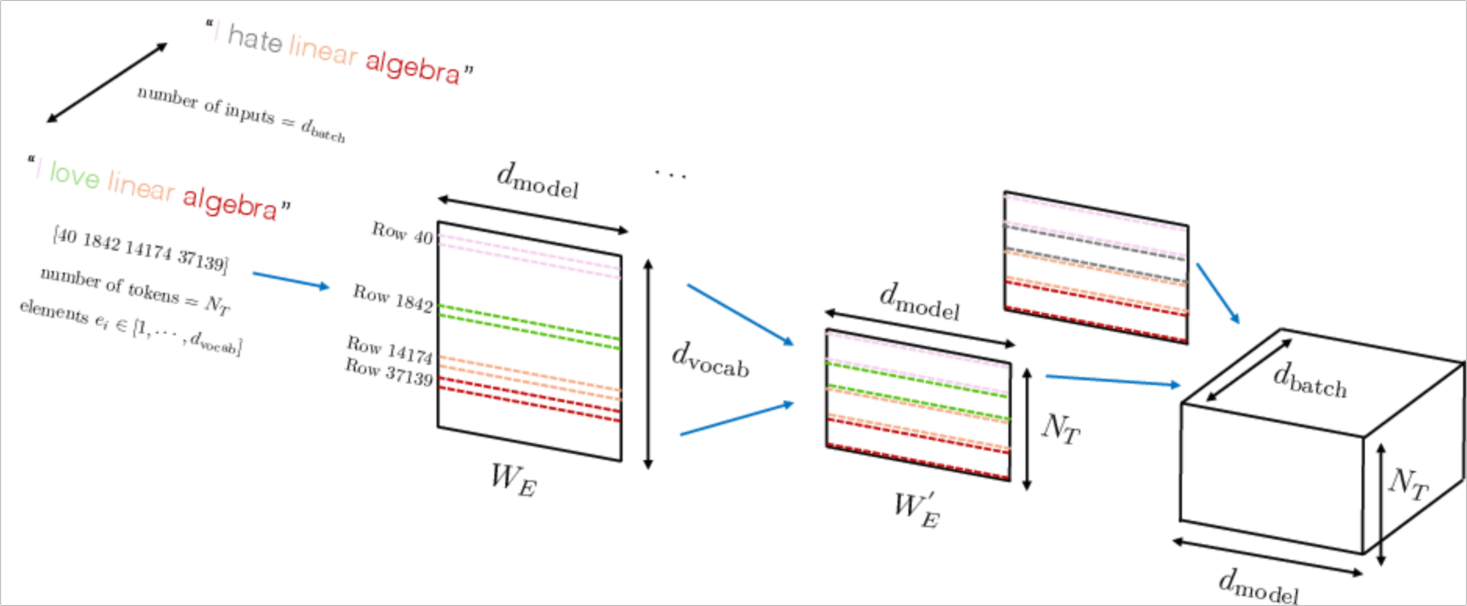

In [18]:
img_source = load(plotsdir()*"/embedding.pdf")

percentage_scale = 50.
new_size = trunc.(Int, size(img_source) .* percentage_scale)
img_rescaled = imresize(img_source, new_size)

In [19]:
struct Embed <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
end

Embed(cfg::TConfig) = Embed(cfg,d->cfg.init_range .* randn(Float32,d))

Embed(cfg::TConfig,py_ln::PyObject) = Embed(cfg,d->w_from_pytorch(py_ln,d,"W_E"))

function LuxCore.initialparameters(rng::AbstractRNG, l::Embed)
    return (weight=l.init_weight((cfg.d_vocab,cfg.d_model)))
end

LuxCore.initialstates(::AbstractRNG, ::Embed) = NamedTuple()

function (ln::Embed)(tokens, W_E, st)
    # W_E : (d_vocab,d_model)
    # tokens : (batch_size,n_ctx)
    
    embed = W_E[tokens .+ 1, :] # julia indexing starts at one

    return embed, st
end

In [20]:
_ = rand_int_test(Embed, (2,4))

output,ref_output = load_gpt2_test(Embed, reference_gpt2.embed, tokens_array);

End Int Test

1.0 of the values are correct

## Positional Embedding

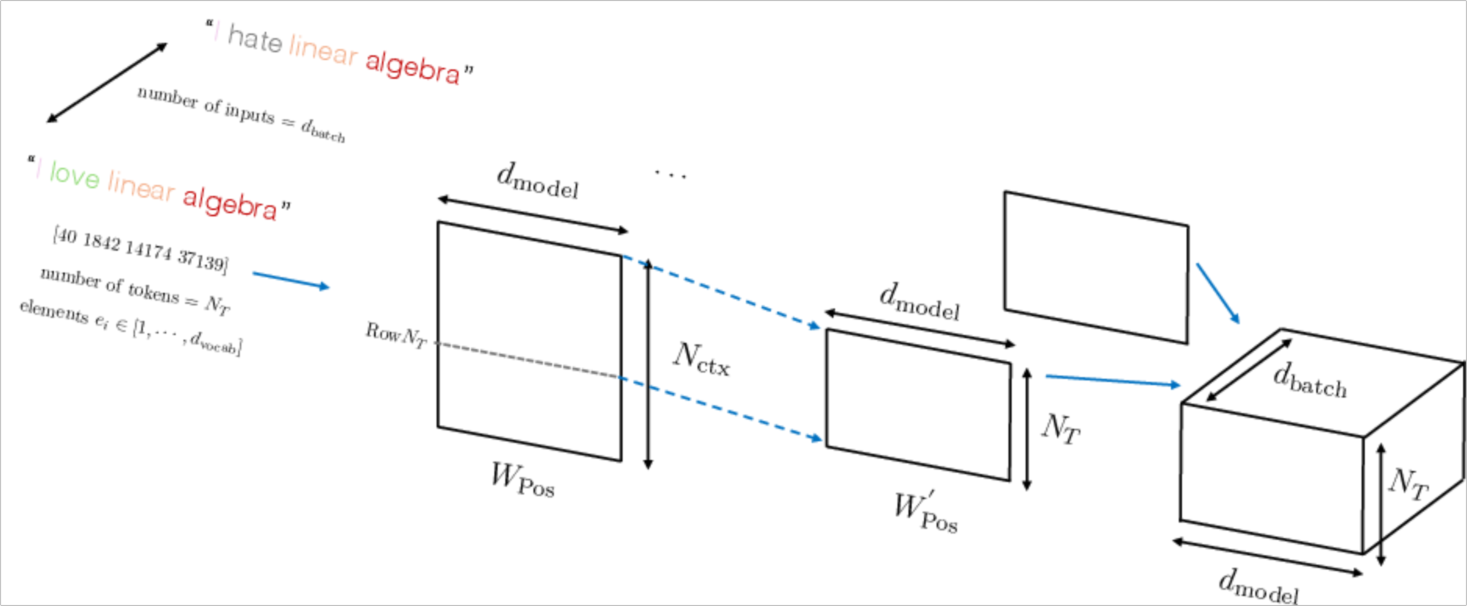

In [21]:
img_source = load(plotsdir()*"/pos_embed.pdf")

percentage_scale = 50.
new_size = trunc.(Int, size(img_source) .* percentage_scale)
img_rescaled = imresize(img_source, new_size)

In [22]:
struct PosEmbed <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
end

PosEmbed(cfg::TConfig) = PosEmbed(cfg,d->cfg.init_range .* randn(Float32,d))

PosEmbed(cfg::TConfig,py_ln::PyObject) = PosEmbed(cfg,d->w_from_pytorch(py_ln,d,"W_pos"))

function LuxCore.initialparameters(rng::AbstractRNG, l::PosEmbed)
    return (weight=l.init_weight((cfg.n_ctx,cfg.d_model)))
end

LuxCore.initialstates(::AbstractRNG, ::PosEmbed) = NamedTuple()

function (ln::PosEmbed)(tokens, W_pos, st)
    # W_pos : (max_ctx,d_model)
    # tokens: 1d tensor :(batch_size,n_ctx)

    nt = size(tokens,2)
    
    # pos_embed = reshape(W_pos[1:nt, :],(1,nt,ln.cfg.d_model)) # [position, d_model]

    pos_embed = permutedims(repeat(W_pos[1:nt, :],inner = (1,1,size(tokens,1))),[3,1,2]) # [position, d_model]

    return pos_embed, st
end

# all(reshape(pos_embed,(1,35,768)) .== einops.repeat(pos_embed, "position d_model -> batch position d_model", batch=tokens.size(0)))

In [23]:
rand_int_test(PosEmbed, (2, 4))

load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens_array);

Output shape:

End Int Test

1.0 of the values are correct

## Attention

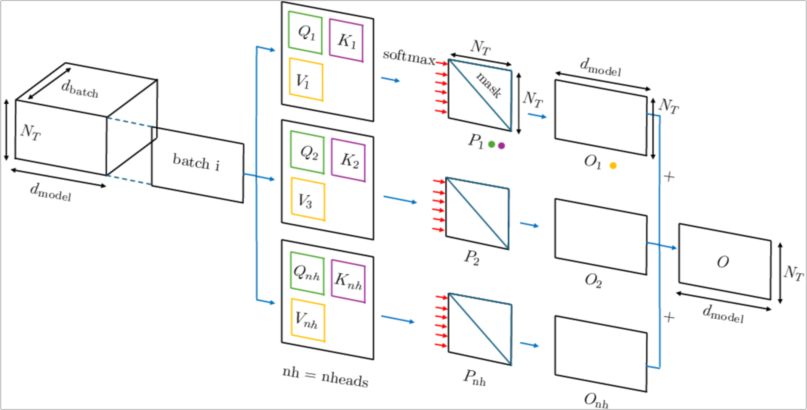

In [24]:
img_source = load(plotsdir()*"/attention.pdf")

percentage_scale = 50.
new_size = trunc.(Int, size(img_source) .* percentage_scale)
img_rescaled = imresize(img_source, new_size)

In [25]:
struct Attention <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
    init_bias
    from_pytorch :: Bool
end

Attention(cfg::TConfig) = Attention(cfg,d->cfg.init_range .* randn(Float32,d),d->zeros32(d...),false)

Attention(cfg::TConfig,py_ln::PyObject) = Attention(cfg,d_dict->multi_w_from_pytorch(py_ln,d_dict),d_dict->multi_b_from_pytorch(py_ln,d_dict),true)

function LuxCore.initialparameters(rng::AbstractRNG, l::Attention) 
    att_W_qkv_dim = (l.cfg.n_heads,l.cfg.d_model,l.cfg.d_head)
    att_b_qkv_dim = (l.cfg.n_heads,l.cfg.d_head)

    att_W_o_dim = (l.cfg.n_heads,l.cfg.d_head,l.cfg.d_model)
    att_b_o_dim = (1,l.cfg.d_model)

    if l.from_pytorch
        W_d_dict = Dict(w=>att_W_qkv_dim for w in ["W_Q","W_K","W_V"])
        b_d_dict = Dict(w=>att_b_qkv_dim for w in ["b_Q","b_K","b_V"])

        W_d_dict["W_O"] = att_W_o_dim
        b_d_dict["b_O"] = att_b_o_dim

        W_all = l.init_weight(W_d_dict)
        b_all = l.init_weight(b_d_dict)

        return (W_Q= W_all["W_Q"],W_K=W_all["W_K"],W_V=W_all["W_V"],W_O=W_all["W_O"],
                b_Q= b_all["b_Q"],b_K=b_all["b_K"],b_V=b_all["b_V"],b_O=b_all["b_O"])
    else
        return (W_Q=l.init_weight(att_W_qkv_dim),W_K=l.init_weight(att_W_qkv_dim),W_V=l.init_weight(att_W_qkv_dim),W_O=l.init_weight(att_W_o_dim),
                b_Q=l.init_bias(att_b_qkv_dim),b_K=l.init_bias(att_b_qkv_dim),b_V=l.init_bias(att_b_qkv_dim),b_O=l.init_bias(att_b_o_dim))
    end
end

LuxCore.initialstates(::AbstractRNG, ::Attention) = NamedTuple()

function apply_causal_mask(A)
    A .+ triu(fill(-Inf,size(A)),1)
end

function (ln::Attention)(I, ps, st)

    # W_Q,K,V = (n_heads,d_model,d_head)

    # W_O = (n_heads,d_head,d_model)

    # I = (n_batch,n_ctx, d_model)

    O = zeros(size(I,1),size(I,2),ln.cfg.d_model)

    for bi in size(I,1)
        for hi in 1:ln.cfg.n_heads
            Qi = I[bi,:,:] * ps.W_Q[hi,:,:] .+ ps.b_Q[hi,:]' # (n_ctx, d_head) .+ (1,d_head)
            Ki = I[bi,:,:] * ps.W_K[hi,:,:] .+ ps.b_K[hi,:]' # (n_ctx, d_head)
            Vi = I[bi,:,:] * ps.W_V[hi,:,:] .+ ps.b_V[hi,:]' # (n_ctx, d_head)

            # Qi*Ki' = (n_ctx, d_head) * (d_head, n_ctx) = (n_ctx,n_ctx)

            Pi = softmax(apply_causal_mask(Qi*Ki' ./ sqrt(ln.cfg.d_head)),dims = 2) # (n_ctx, n_ctx)

            Zi = Pi * Vi  # (n_ctx, d_head)

            Oi = Zi * ps.W_O[hi,:,:] # (n_ctx, d_head) * (d_head,d_model) = (n_ctx, d_model)

            O[bi,:,:] .+= Oi 
        end

        O[bi,:,:] .+=  ps.b_O
    end

    return O,st

end


In [26]:
attn = Attention(cfg,reference_gpt2.blocks[0].attn)

Attention()         # 2_362_368 parameters

In [27]:
rand_float_test(Attention, (2, 4, 768));

Input shape:(2, 4, 768)

End Float Test

In [28]:
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, "blocks.0.ln1.hook_normalized",true);

Reference output shape:(1, 5, 768)

1.0 of the values are correct

## MLP

In [29]:
struct MLP <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
    init_bias
    from_pytorch :: Bool
end

MLP(cfg::TConfig) = MLP(cfg,d->cfg.init_range .* randn(Float32,d),d->zeros32(d...),false)

MLP(cfg::TConfig,py_ln::PyObject) = MLP(cfg,d_dict->multi_w_from_pytorch(py_ln,d_dict),d_dict->multi_b_from_pytorch(py_ln,d_dict),true)

function LuxCore.initialparameters(rng::AbstractRNG, l::MLP) 

    W_in_dim = (l.cfg.d_model,l.cfg.d_mlp)
    W_out_dim = (l.cfg.d_mlp,l.cfg.d_model)

    b_in_dim = (1,l.cfg.d_mlp)
    b_out_dim = (1,l.cfg.d_model)

    if l.from_pytorch
        W_d_dict = Dict("W_in"=>W_in_dim,"W_out"=>W_out_dim)
        b_d_dict = Dict("b_in"=>b_in_dim,"b_out"=>b_out_dim)

        W_all = l.init_weight(W_d_dict)
        b_all = l.init_weight(b_d_dict)

        return (W_in= W_all["W_in"],W_out=W_all["W_out"],b_in=b_all["b_in"],b_out=b_all["b_out"])
    else
        return (W_in=l.init_weight(W_in_dim),W_out=l.init_weight(W_out_dim),b_in=l.init_bias(b_in_dim),b_out = l.init_bias(b_out_dim))
    end
end

LuxCore.initialstates(::AbstractRNG, ::MLP) = NamedTuple()

GELU(x)=0.5*x*(1+tanh(sqrt(2/π)*(x+0.044715*x^3))) 

function (ln::MLP)(I, ps, st)
    # normalized_resid_mid (I) : [batch, position, d_model]
    # normalized_resid_mid (I) : (n_batch, n_ctx, d_model)

    # W_in : (d_model,d_mlp)
    # W_out  : (d_mlp,d_model)

    out = zeros(size(I,1),size(I,2),ln.cfg.d_model)

    for bi in size(I,1)
        out[bi,:,:] .= GELU.(I[bi,:,:] * ps.W_in .+ ps.b_in) * ps.W_out .+ ps.b_out
    end

    return out, st
end

In [30]:
rand_float_test(MLP, (2, 4, 768));

load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, "blocks.0.ln2.hook_normalized");

Input shape:(2, 4, 768)

1.0 of the values are correct

## Transformer Block

In [31]:
struct TransformerBlock <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    ln1
    attn
    ln2
    mlp
end

TransformerBlock(cfg::TConfig) = TransformerBlock(cfg,TLayerNorm(cfg),Attention(cfg),TLayerNorm(cfg),MLP(cfg))

TransformerBlock(cfg::TConfig,py_ln::PyObject) =  TransformerBlock(cfg,TLayerNorm(cfg,py_ln.ln1),Attention(cfg,py_ln.attn),TLayerNorm(cfg,py_ln.ln2),MLP(cfg,py_ln.mlp))

function LuxCore.initialparameters(rng::AbstractRNG, l::TransformerBlock) 

    ps_ln1, st_ln1 = LuxCore.setup(rng, l.ln1)
    ps_attn, st_attn = LuxCore.setup(rng, l.attn)
    ps_ln2, st_ln2 = LuxCore.setup(rng, l.ln2)
    ps_mlp, st_mlp = LuxCore.setup(rng, l.mlp)

    return (ln1=ps_ln1, attn = ps_attn, ln2=ps_ln2, mlp=ps_mlp)

end

function LuxCore.initialstates(rng::AbstractRNG, l::TransformerBlock) 
    ps_ln1, st_ln1 = LuxCore.setup(rng, l.ln1)
    ps_attn, st_attn = LuxCore.setup(rng, l.attn)
    ps_ln2, st_ln2 = LuxCore.setup(rng, l.ln2)
    ps_mlp, st_mlp = LuxCore.setup(rng, l.mlp)

    return (ln1=st_ln1, attn = st_attn, ln2=st_ln2, mlp=st_mlp)
end

function (ln::TransformerBlock)(I, ps, st)
    # resid_pre (I) : [batch, position, d_model]
    # resid_pre (I) : (n_batch, n_ctx, d_model)

    normalized_resid_pre,st_ln1 = ln.ln1(I, ps.ln1, st.ln1)
    attn_out,st_attn = ln.attn(normalized_resid_pre, ps.attn, st.attn)
    resid_mid = I .+ attn_out
    
    normalized_resid_mid,st_ln2 = ln.ln2(resid_mid, ps.ln2, st.ln2)
    mlp_out,st_mlp = ln.mlp(normalized_resid_mid, ps.mlp, st.mlp)
    resid_post = resid_mid .+ mlp_out
    
    return resid_post,(ln1=st_ln1,attn=st_attn,ln2=st_ln2,mlp=st_mlp)
end

In [32]:
tf2 = TransformerBlock(cfg)

TransformerBlock()  # 7_087_872 parameters

In [33]:
tf2 = TransformerBlock(cfg,reference_gpt2.blocks[0])

TransformerBlock()  # 7_087_872 parameters

In [34]:
rand_float_test(TransformerBlock, (2, 4, 768));

load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], "blocks.0.hook_resid_pre");

Input shape:(2, 4, 768)

Output shape:

1.0 of the values are correct

## Unembedding

In [35]:
struct Unembed <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    init_weight
    init_bias
end

Unembed(cfg::TConfig) = Unembed(cfg,d->cfg.init_range .* randn(Float32,d),d->zeros(Float32,d))

Unembed(cfg::TConfig,py_ln::PyObject) = Unembed(cfg,d->w_from_pytorch(py_ln,d,"W_U"),d->b_from_pytorch(py_ln,d,"b_U"))

function LuxCore.initialparameters(rng::AbstractRNG, l::Unembed)
    return (W_U=l.init_weight((cfg.d_model,cfg.d_vocab)),b_U=l.init_bias((1,cfg.d_vocab)))
end

LuxCore.initialstates(::AbstractRNG, ::Unembed) = NamedTuple()

function (ln::Unembed)(I, ps, st)
    # W_U : (d_model,d_vocab)
    # normalized_resid_final (I) : (n_batch,n_ctx,d_model)

    logits = zeros(size(I,1),size(I,2),cfg.d_vocab)

    for bi in size(I,1)
        logits[bi,:,:] .= I[bi,:,:] * ps.W_U .+ ps.b_U # (n_ctx,d_model) * (d_model,d_vocab) 
    end

    return logits, st
end

In [36]:
rand_float_test(Unembed, (2, 4, 768))

load_gpt2_test(Unembed, reference_gpt2.unembed, "ln_final.hook_normalized");

Input shape:(2, 4, 768)

Input shape:

1.0 of the values are correct

## Full Transformer

In [37]:
struct Transformer <: LuxCore.AbstractExplicitLayer
    cfg :: TConfig
    embed
    pos_embed
    blocks
    ln_final
    unembed
end

Transformer(cfg::TConfig) = Transformer(cfg,Embed(cfg),PosEmbed(cfg),[TransformerBlock(cfg) for _ in 1:cfg.n_layers],TLayerNorm(cfg),Unembed(cfg))

Transformer(cfg::TConfig,py_ln::PyObject) =   Transformer(cfg,Embed(cfg,py_ln.embed),PosEmbed(cfg,py_ln.pos_embed),[TransformerBlock(cfg,py_ln.blocks[i]) for i in 1:cfg.n_layers],TLayerNorm(cfg,py_ln.ln_final),Unembed(cfg,py_ln.unembed))

function LuxCore.initialparameters(rng::AbstractRNG, l::Transformer) 

    ps_embed, st_embed = LuxCore.setup(rng, l.embed)
    ps_pos_embed, st_pos_embed = LuxCore.setup(rng, l.pos_embed)
    ps_blocks = first.([LuxCore.setup(rng, l.blocks[i]) for i in 1:cfg.n_layers])
    ps_ln_final, st_ln_final = LuxCore.setup(rng, l.ln_final)
    ps_unembed, st_unembed = LuxCore.setup(rng, l.unembed)

    return (embed=ps_embed, pos_embed = ps_pos_embed, blocks=ps_blocks, ln_final=ps_ln_final,unembed = ps_unembed)

end

function LuxCore.initialstates(rng::AbstractRNG, l::Transformer) 
    ps_embed, st_embed = LuxCore.setup(rng, l.embed)
    ps_pos_embed, st_pos_embed = LuxCore.setup(rng, l.pos_embed)
    st_blocks = last.([LuxCore.setup(rng, l.blocks[i]) for i in 1:cfg.n_layers])
    ps_ln_final, st_ln_final = LuxCore.setup(rng, l.ln_final)
    ps_unembed, st_unembed = LuxCore.setup(rng, l.unembed)

    return (embed=st_embed, pos_embed = st_pos_embed, blocks=st_blocks, ln_final=st_ln_final,unembed = st_unembed)
end

function (ln::Transformer)(tokens, ps, st)
    # tokens (I) : [batch, position, d_model]
    # tokens (I) : (n_batch, n_ctx, d_model)

    embed, st_embed = ln.embed(tokens,ps.embed,st.embed)
    pos_embed, st_pos_embed = ln.pos_embed(tokens,ps.pos_embed,st.pos_embed)
    residual = embed .+ pos_embed

    st_blocks = []

    for (n,block) in enumerate(ln.blocks)
        residual,st_block = block(residual,ps.blocks[n],st.blocks[n])
        push!(st_blocks,st_block)
    end

    normalized_resid_final, st_ln_final = ln.ln_final(residual,ps.ln_final,st.ln_final)
    logits, st_unembed = ln.unembed(normalized_resid_final,ps.unembed,st.unembed)
    # logits have shape [batch, position, logits]
    return logits,(embed=st_embed, pos_embed = st_pos_embed, blocks=st_blocks, ln_final=st_ln_final,unembed = st_unembed)
end



In [38]:
TF = Transformer(cfg,reference_gpt2)

ps, st = LuxCore.setup(rng, TF);

In [39]:
rand_int_test(Transformer, (2, 4));

Output shape:

End Int Test

In [40]:
load_gpt2_test(Transformer, reference_gpt2, tokens_array);

Output shape:

1.0 of the values are correct

## Lets test!

In [68]:
reference_text = "The dog ate the tasty"

tokens = reference_gpt2.to_tokens(reference_text)

tokens_array = tokens.cpu().detach().numpy()

1×6 Matrix{Int64}:
 50256  464  3290  15063  262  25103

In [69]:
output = LuxCore.apply(TF, tokens_array, ps, st)[1];

In [70]:
reference_gpt2.tokenizer.decode(argmax(output[1,end,:]) - 1)

" food"

To conclude, I hope somebody finds this useful! I see lots of interesting directions I want to explore. One of them is to integrate this model with the SciML tools to possibly explore Deep Equilibrium Transformers (https://github.com/SciML/DeepEquilibriumNetworks.jl) . I'm interested in the interpretation of transformers as dynamical systems (see- https://people.lids.mit.edu/yp/homepage/data/2023_transformers2.pdf and # https://mcbal.github.io/post/transformer-attention-as-an-implicit-mixture-of-effective-energy-based-models/). I think this interpretation could be useful for interpretabiity and consequently safety. 